**Plot Extended Figures**

In [7]:
library(patchwork)
library(ggplot2)
library(magick)
library(tidytext)
library(SingleCellExperiment)
library(tidyHeatmap)
library(dplyr)
library(tidyr)
library(ggplot2)
library(ggrepel)
library(gridExtra)
library(RColorBrewer)
library(reshape2)
library(grid)
library(ggpubr)  # Import ggpubr to provide the stat_compare_means function

source('../../ABCA7lof2/plotting.r')

ERROR: Error in library(SingleCellExperiment): there is no package called ‘SingleCellExperiment’


In [3]:
# check if output directory exists, if not create it, and download the necessary file in R

path <- "../../processed_data/"

if (!dir.exists(path)) {
  dir.create(path, recursive = TRUE)
}

urls <- c('https://storage.googleapis.com/abca7lof/welch_et_al_bulk_rna/human_bulk_RNAseq.sce.rds',
'https://storage.googleapis.com/abca7lof/scRNAseq/processed_data/stats_input_data_0825.rds')

for (url in urls) {
    local_filename <- file.path(path, basename(url))
    download.file(url, destfile = local_filename, mode = "wb")
    cat("Download completed!\n")
}



Download completed!
Download completed!


In [4]:
all_data = readRDS('../../processed_data/stats_input_data_0825.rds')

# get the welch et al data
data = readRDS('../../processed_data/human_bulk_RNAseq.sce.rds')
norm_counts = assays(data)$log2rpkm
genes = c('ABCA7', 'ABCA1', 'APOE','NEUROD1')
all_p = list()

for(n in genes){
    df = as.data.frame(norm_counts[n,])
    df$pop = (colData(data)$population)
    df$grp = colData(data)$id
    df$cond = colData(data)$condition
    df$AD = colData(data)$AD
    df = df[df$cond=='ctr',]
    
    colnames(df) = c('gene','label', 'grp', 'condition')
    df$label = factor(df$label, , levels=c('NeuN-', 'NeuN+'))
    all_p[[n]] = ggplot(df, aes(y=gene, x=as.factor(label), fill = as.factor(label)))  + xlab('') + ylab('normalized expression') + ggtitle(n) + geom_boxplot()  + geom_point()+ geom_line(aes(group = grp), alpha=.2)+ stat_compare_means(method = 't.test', paired = TRUE) + theme_classic() +  scale_fill_manual(values = c( "grey", "seagreen3"))+ theme(legend.position = "none")+scale_y_continuous(expand = expansion(mult = c(0.05, 0.15)))
}

all_p2 = list()
ind = Reduce(intersect, lapply(all_data$av_logcounts_by_ind, function(x) colnames(x)))
                               
for(n in genes){
    exp = do.call('rbind', lapply(all_data$av_logcounts_by_ind, function(x) x[n,ind]))
    df = melt(exp)
    df$grp = ifelse(df$Var1%in%c('Ex', 'In'), 'neurons', 'glia')
    temp = aggregate(df$value, list(interaction(df$grp, df$Var2)), 'mean')
    temp = separate(
      temp,
      c('Group.1'),
      c('grp', 'projid'),
      sep = "[.]")

    all_p2[[n]] = ggplot(temp, aes(y=((as.numeric(x))), x=grp, fill = factor(grp)), col = 'black') + scale_y_continuous(expand = expansion(mult = c(0.05, 0.15))) + 
       geom_boxplot(width = .8, alpha = 1) + theme_classic() +theme(legend.position = "none") + ggtitle(n) + ylab('normalized expression') + xlab('') + scale_fill_manual(values = c( "grey", "seagreen3")) + geom_line(aes(group = projid), alpha = .2)+ stat_compare_means(method = 't.test', paired = TRUE)+ theme(legend.position = "none")
}
                                  
options(repr.plot.width=5, repr.plot.height=5)

plots1 = all_p$ABCA7 | all_p$ABCA1  | all_p$APOE | all_p$NEUROD1 
plots2 = all_p2$ABCA7 | all_p2$ABCA1 | all_p2$APOE | all_p2$NEUROD1

In [5]:
plots1 <- plots1 + plot_annotation(title = "Welch et al. Bulk RNA-Seq Expression by FAC-sorting")
plots2 <- plots2 + plot_annotation(title = "this scRNA-seq dataset")


In [6]:
pdf('../../paper/extended_plots/welch_et_al_bulk_rna.pdf', width=11, height=2.5)
plots1
dev.off()   

pdf('../../paper/extended_plots/scRNAseq_bulk_rna.pdf', width=11, height=2.5)
plots2
dev.off()

pdf 
  2

pdf 
  2

In [6]:
all_data = readRDS('../../processed_data/stats_input_data_0825.rds')

col = readRDS('../../processed_data/Cell_group_colors.rds')
# plot ABCA7 detection rate
x = all_data$det.rate.celltype['ABCA7',]
x = x[order(-1*x)]
library(ggplot2)

df <- data.frame(
  cell_type = names(x),
  detection_rate = as.numeric(x)
)

png('../../paper/extended_plots/abca7_detection_rate.png', width=3, height=3, units='in', res=300)
ggplot(df, aes(x = reorder(cell_type, -detection_rate), y = detection_rate, fill = cell_type)) +
  geom_bar(stat = "identity") +
  scale_fill_manual(values = col) +
  labs(y = 'fraction of cells where ABCA7 counts > 0', 
       title = 'ABCA7 detection rate by cell type', x = '') +
  theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 1, size = 11, colour = "black"),
        axis.text.y = element_text(size = 11, colour = "black"),
        axis.title = element_text(size = 11),
        plot.title = element_text(size = 11),
        legend.position = "none",
        panel.background = element_rect(fill = "white", colour = "white"),
        axis.line = element_line(colour = "black"))
dev.off()






pdf 
  2

In [4]:
colors = readRDS('../processed_data/Cell_group_colors.rds')
cols = c('grey', 'red')
names(cols) = c('Con', 'LoF')

source('../ABCA7lof2/degs.r')

In [15]:
library(ggplot2)
library(ggpubr)
library(dplyr)

boxplot_w_stats <- function(df, x, y, group_color = x, group_fill = x, alpha = 0.5, palette, xlab = '', ylab = '', width = 0.5, stats_method = 'wilcox', comparisons) {
  # Calculate summary including mean and sd
  stats_df <- df %>%
    group_by_at(vars(x)) %>%
    summarise(Mean = mean(!!rlang::sym(y)), SD = sd(!!rlang::sym(y)), .groups = 'drop')
  
  # Join the calculated means and SD back to the original df
  df <- inner_join(df, stats_df, by = c(x = x))

  # Create the boxplot
  plot <- ggboxplot(df, x = x, y = y,
                    color = group_color, fill = group_fill, alpha = alpha, palette = palette,
                    xlab = xlab, ylab = ylab, width = width) +
          geom_errorbar(aes(ymin = Mean - SD, ymax = Mean + SD), width = 0.2) +
          stat_compare_means(method = stats_method, comparisons = comparisons) +
          geom_jitter(alpha = 0.3) +
          theme(axis.text.x = element_text(angle = 0, vjust = 0.5, hjust = 1))
  
  return(plot + scale_y_continuous(expand = expansion(mult = c(0, 0.1))))
}


In [16]:
# proteomics data
proteomics = read.csv('..//processed_data//for_plotting/ABCA7_proteomics.csv')

proteomics$LOF = ifelse(proteomics$LOF==1, 'LoF', 'Con')
proteomics$LOF = factor(proteomics$LOF, levels = c('Con', 'LoF'))

p000 = boxplot_w_stats(df = proteomics, x = 'LOF', y = 'ABCA7', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'ABCA7', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('All')

Warning message:
“Using an external vector in selections was deprecated in tidyselect 1.1.0.
ℹ Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(x)

  # Now:
  data %>% select(all_of(x))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.”


ERROR: [1m[33mError[39m in `inner_join()`:[22m
[1m[22m[33m![39m Join columns in `x` must be present in the data.
[31m✖[39m Problem with `x`.


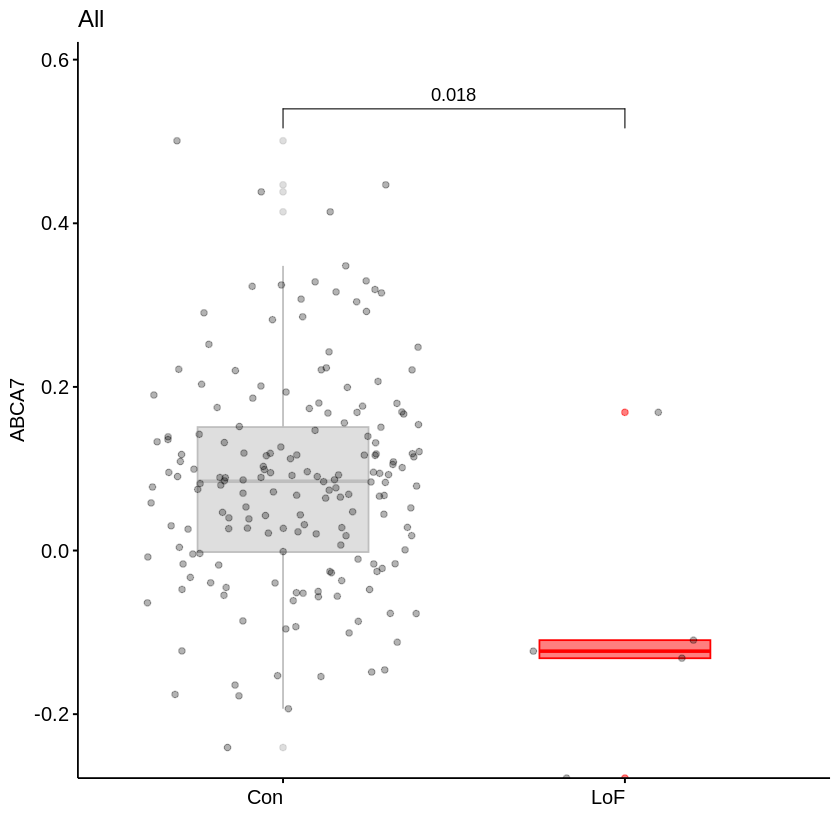

In [12]:
p000

#### Extended Figure Cohort metadata overview


Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in wilcox.test.default(c(1.15125, 11.79375, 0, 6.93833333333333, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(5.25, 5.83333333333333, 4.08333333333333, :
“cannot compute exact p-value with ties”


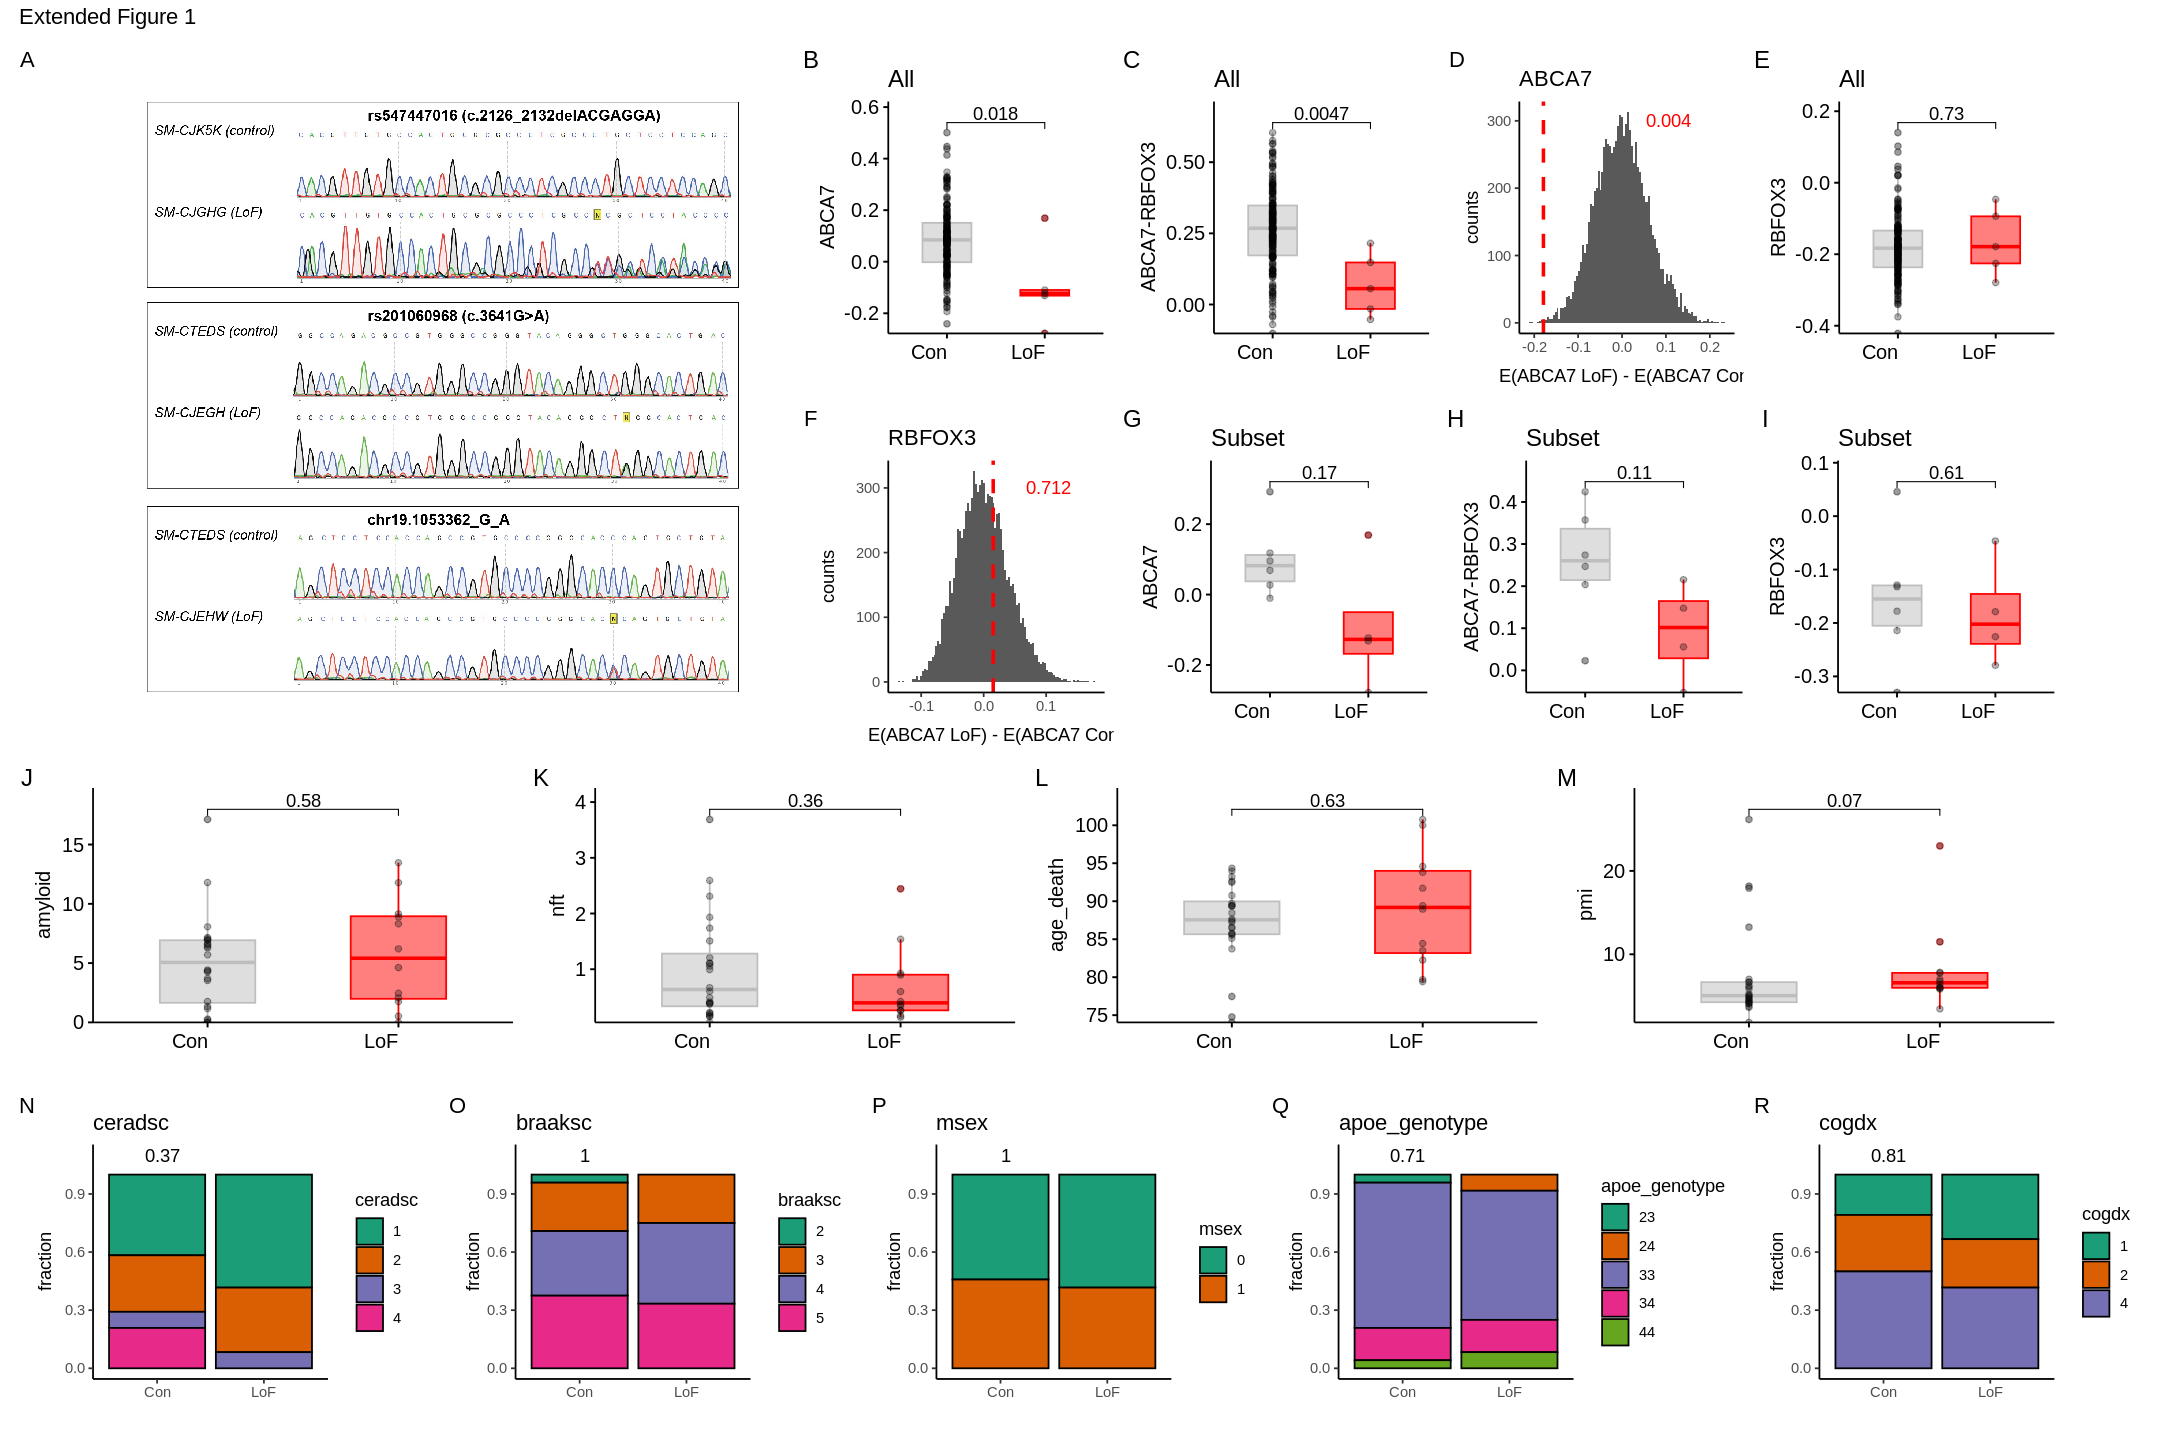

In [3]:
# proteomics data
proteomics = read.csv('.//processed_data//for_plotting/ABCA7_proteomics.csv')

proteomics$LOF = ifelse(proteomics$LOF==1, 'LoF', 'Con')
proteomics$LOF = factor(proteomics$LOF, levels = c('Con', 'LoF'))

p000 = boxplot_w_stats(df = proteomics, x = 'LOF', y = 'ABCA7', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'ABCA7', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('All')
p001 = boxplot_w_stats(df = proteomics, x = 'LOF', y = 'RBFOX3', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'RBFOX3', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('All')
p002 = boxplot_w_stats(df = proteomics[proteomics$grp==TRUE,], x = 'LOF', y = 'ABCA7', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'ABCA7', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('Subset')
p003 = boxplot_w_stats(df = proteomics[proteomics$grp==TRUE,], x = 'LOF', y = 'RBFOX3', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'RBFOX3', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('Subset')
p004 = get_permutation_plot('RBFOX3', proteomics)
p005 = get_permutation_plot('ABCA7', proteomics)

proteomics$norm_ABCA7 = proteomics$ABCA7-proteomics$RBFOX3
pi = boxplot_w_stats(df = proteomics, x = 'LOF', y = 'norm_ABCA7', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'ABCA7-RBFOX3', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('All')
pii = boxplot_w_stats(df = proteomics[proteomics$grp==TRUE,], x = 'LOF', y = 'norm_ABCA7', palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = 'ABCA7-RBFOX3', width = .5, alpha = .5)+ theme(legend.position="none")+ggtitle('Subset')

plot_grp0 = (((p000|pi|p005|p001)/(p004|p002|pii|p003)))

# metadata
all_data = readRDS('./processed_data/single_cell/stats_input_data_0825.rds')

# load the data
features = c('amyloid', 'nft','age_death', 'pmi')

# continuous variables by variant
metadata = all_data$summary
metadata$LOF = ifelse(metadata$LOF==1, 'LoF', 'Con')
metadata$LOF = factor(metadata$LOF, levels = c('Con', 'LoF'))

plt00 = boxplot_w_stats(df = as.data.frame(metadata), x = 'LOF', y = features[1], palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = features[1], width = .5, alpha = .5)+ theme(legend.position="none")
plt01 = boxplot_w_stats(df = as.data.frame(metadata), x = 'LOF', y = features[2], palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = features[2], width = .5, alpha = .5)+ theme(legend.position="none")
plt02 = boxplot_w_stats(df = as.data.frame(metadata), x = 'LOF', y = features[3], palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = features[3], width = .5, alpha = .5)+ theme(legend.position="none")
plt03 = boxplot_w_stats(df = as.data.frame(metadata), x = 'LOF', y = features[4], palette = cols, comparisons = list(c('Con', 'LoF')), xlab = '', ylab = features[4], width = .5, alpha = .5)+ theme(legend.position="none")

# categorical variables by genotype
features = c('braaksc', 'ceradsc', 'msex','apoe_genotype', 'cogdx')
plt10 = get_barplot(as.data.frame(metadata), 'LOF', features[1])
plt11 = get_barplot(as.data.frame(metadata), 'LOF', features[2])
plt12 = get_barplot(as.data.frame(metadata), 'LOF', features[3])
plt13 = get_barplot(as.data.frame(metadata), 'LOF', features[4])
plt14 = get_barplot(as.data.frame(metadata), 'LOF', features[5])
#plt15 = get_barplot(as.data.frame(metadata), 'LOF', features[6])

cont_plots = (plt00|plt01|plt02|plt03)#|plt04)
disc_plots = (plt11|plt10|plt12|plt13|plt14)

# get the images
img = image_ggplot(image_read('./pdf_figures/pm_variants.png'))#, native = TRUE)

# show all 
options(repr.plot.width=18, repr.plot.height=12)

extended1 = (((img|plot_grp0) + plot_layout(widths=c(1.2,2)))/(cont_plots/disc_plots + plot_layout(heights = c(1, 1)))) + plot_layout(heights=c(1,1)) + plot_annotation(tag_levels = 'A', title='Extended Figure 1')
extended1

In [30]:
pdf('./pdf_figures/Extended_Figure_1.pdf', width=18, height=12)
extended1
dev.off()

Warning message in wilcox.test.default(c(1.15125, 11.79375, 0, 6.93833333333333, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(5.25, 5.83333333333333, 4.08333333333333, :
“cannot compute exact p-value with ties”


png 
  2

#### Extended Figure Sample swap results

png 
  2

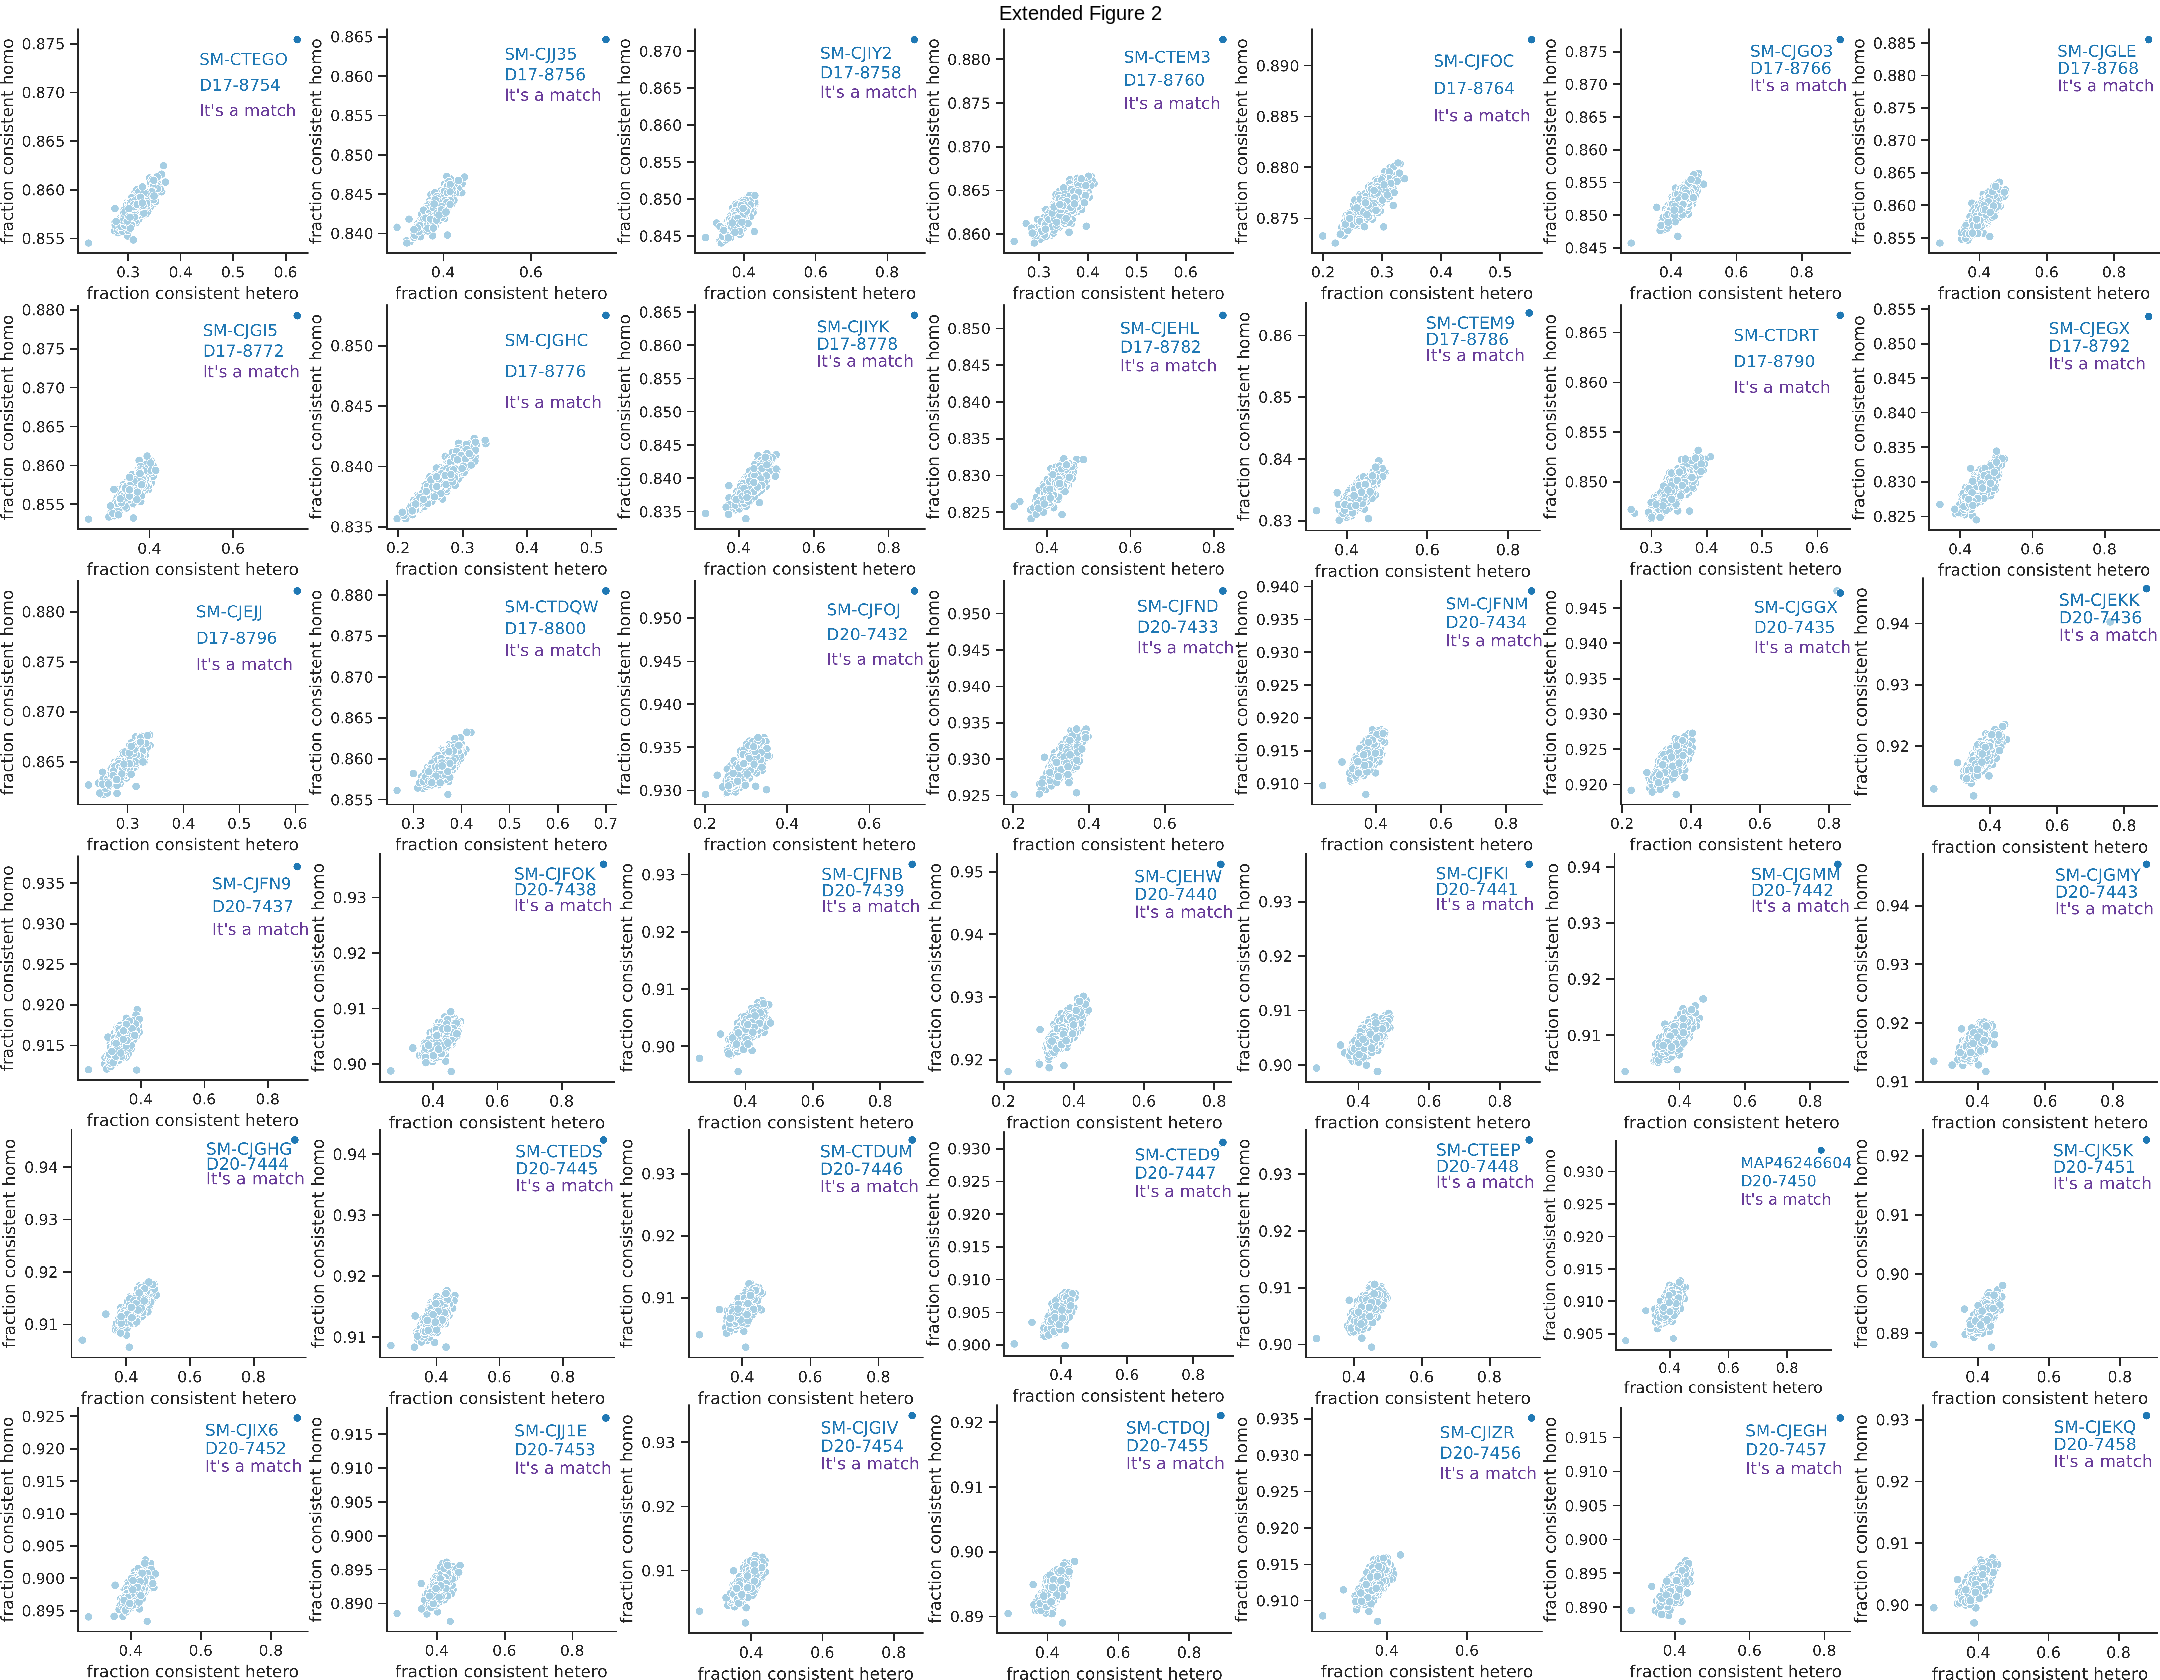

In [31]:
files = list.files(path = "./pdf_figures/.")
files = files[unlist(lapply(files, function(x) endsWith(x,'swap_res.pdf')))]
                            
plots = list()
for(i in 1:length(files)){
    plots[[i]] = image_ggplot(image_trim(image_read_pdf(paste0('./pdf_figures/', files[i]))))
}
     
options(repr.plot.width=18, repr.plot.height=14)

pdf('./pdf_figures/Extended_Figure_2.pdf', width=18, height=14)
do.call("grid.arrange", c(plots, ncol=7, top='Extended Figure 2'))#+ggtitle('Extended Figure 1')
dev.off()
                            
do.call("grid.arrange", c(plots, ncol=7, top='Extended Figure 2'))#+ggtitle('Extended Figure 1')


#### Extended Figure batch correction overview

In [11]:
# metadata
all_data = readRDS('./processed_data/single_cell//stats_input_data_0825.rds')

# cell coordinates
coords = read.csv('./processed_data//single_cell//coords.csv', row.names=1)
colnames(coords) = c('x', 'y')

# DEGS (JBM, all..)
degs = readRDS('./processed_data/single_cell//pseudobulk_degs_0825.rds')

# load the data
features = c('amyloid', 'nft','age_death', 'pmi')

# continuous variables by variant
metadata = all_data$summary
metadata$seq_batch = ifelse(metadata$seq_batch=='JBM', 'batch_1', 'batch_2')
metadata$seq_batch = factor(metadata$seq_batch, levels = c('batch_1', 'batch_2'))
metadata$LOF = ifelse(metadata$LOF==1, 'LoF', 'Con')
cols_batch = c('blue', 'pink')
names(cols_batch) = c('batch_1', 'batch_2')

cols = c('grey', 'red')
names(cols) = c('Con', 'LoF')

plt00 = boxplot_w_stats(df = as.data.frame(metadata), x = 'seq_batch', y = features[1], palette = cols_batch, comparisons = list(c('batch_1', 'batch_2')), xlab = '', ylab = features[1], width = .5, alpha = .5)+ theme(legend.position="none")
plt01 = boxplot_w_stats(df = as.data.frame(metadata), x = 'seq_batch', y = features[2], palette = cols_batch, comparisons = list(c('batch_1', 'batch_2')), xlab = '', ylab = features[2], width = .5, alpha = .5)+ theme(legend.position="none")
plt02 = boxplot_w_stats(df = as.data.frame(metadata), x = 'seq_batch', y = features[3], palette = cols_batch, comparisons = list(c('batch_1', 'batch_2')), xlab = '', ylab = features[3], width = .5, alpha = .5)+ theme(legend.position="none")
plt03 = boxplot_w_stats(df = as.data.frame(metadata), x = 'seq_batch', y = features[4], palette = cols_batch, comparisons = list(c('batch_1', 'batch_2')), xlab = '', ylab = features[4], width = .5, alpha = .5)+ theme(legend.position="none")
#plt04 = boxplot_w_stats(df = as.data.frame(metadata), x = 'seq_batch', y = features[5], palette = cols_batch, comparisons = list(c('batch_1', 'batch_2')), xlab = '', ylab = features[5], width = .5, alpha = .5)+ theme(legend.position="none")

# categorical variables by genotype
features = c('braaksc', 'ceradsc','msex','apoe_genotype', 'cogdx')
plt10 = get_barplot(as.data.frame(metadata), 'seq_batch', features[1])
plt11 = get_barplot(as.data.frame(metadata), 'seq_batch', features[2])
plt12 = get_barplot(as.data.frame(metadata), 'seq_batch', features[3])
plt13 = get_barplot(as.data.frame(metadata), 'seq_batch', features[4])
plt14 = get_barplot(as.data.frame(metadata), 'seq_batch', features[5])

cont_plots = (plt00|plt01|plt02|plt03)#|plt04)
disc_plots = (plt10|plt11|plt12|plt13|plt14)

colData = read.csv('./processed_data/single_cell/colData.csv')
coords = colData[,c('x', 'y', 'ABCA7LoF', 'seq_batch', 'gaussian_liklihood', 'annotations2', 'projid', 'total_counts', 'mito_fractions')]
coords$LoF = ifelse(coords$ABCA7LoF==1, 'LoF', 'Con')
coords$seq_batch = ifelse(coords$seq_batch=='JBM', 'batch_1', 'batch_2')
coords$node_centrality = coords$gaussian_liklihood
coords$projid = as.character(coords$projid)
coords$ABCA7LoF = ifelse(coords$ABCA7LoF==1, 'LoF', 'Con')

# coord plots
size = 7
C1 = plot_coords_by_grp(coords, 'x', 'y', 'ABCA7LoF', 'gaussian_liklihood', cols, S=1e-100)+
annotate(geom="text", x=-2, y=13, label="ABCA7 LoF",color=cols['LoF'], size=6, fontface='italic')+
annotate(geom="text", x=12, y=13, label="ABCA7 Con",color=cols['Con'], size=6, fontface='italic')

n <- length(unique(coords$projid))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
names(col_vector) = as.character(unique(coords$projid))

C2 = plot_coords_by_grp(coords, 'x', 'y', 'projid', 'gaussian_liklihood', col_vector, S=1e-100)

cols_batch = c('pink', 'blue')
names(cols_batch) = c('batch_1', 'batch_2')

batch1 = plot_coords_by_grp(coords[coords$seq_batch=='batch_1',], 'x', 'y', 'seq_batch', 'gaussian_liklihood', cols_batch, S=1e-100)+
annotate(geom="text", x=-2, y=20, label="Batch #1",color='black', size=size, fontface='italic')

batch2 = plot_coords_by_grp(coords[coords$seq_batch=='batch_2',], 'x', 'y', 'seq_batch', 'gaussian_liklihood', cols_batch, S=1e-100)+
annotate(geom="text", x=-2, y=20, label="Batch #2",color='black', size=size, fontface='italic')

batch3 = plot_coords_by_grp(coords, 'x', 'y', 'seq_batch', 'gaussian_liklihood', cols_batch, S=1e-100)

df = as.data.frame(table(coords$celltype, coords$batch))
props = ggplot(coords, aes(x=seq_batch, fill=annotations2), color='black') + geom_bar(position = "fill", color='black')+ scale_fill_manual(values = (colors[as.character(unique(coords$annotations2))])) + theme_classic() + ylab('proportion') + xlab('')

In [18]:
png('./pdf_figures/Extended_Figure_3_cells1.png', res=300, width=5000, height=5000)
C2
dev.off()
png('./pdf_figures/Extended_Figure_3_cells2.png', res=300, width=5000, height=5000)
batch1
dev.off()
png('./pdf_figures/Extended_Figure_3_cells3.png', res=300, width=5000, height=5000)
batch2
dev.off()

png 
  2

png 
  2

png 
  2

Warning message in wilcox.test.default(c(0, 1.15125, 11.79375, 0.531, 0, 6.93833333333333, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(6, 5.25, 5.83333333333333, 7, 4.08333333333333, :
“cannot compute exact p-value with ties”


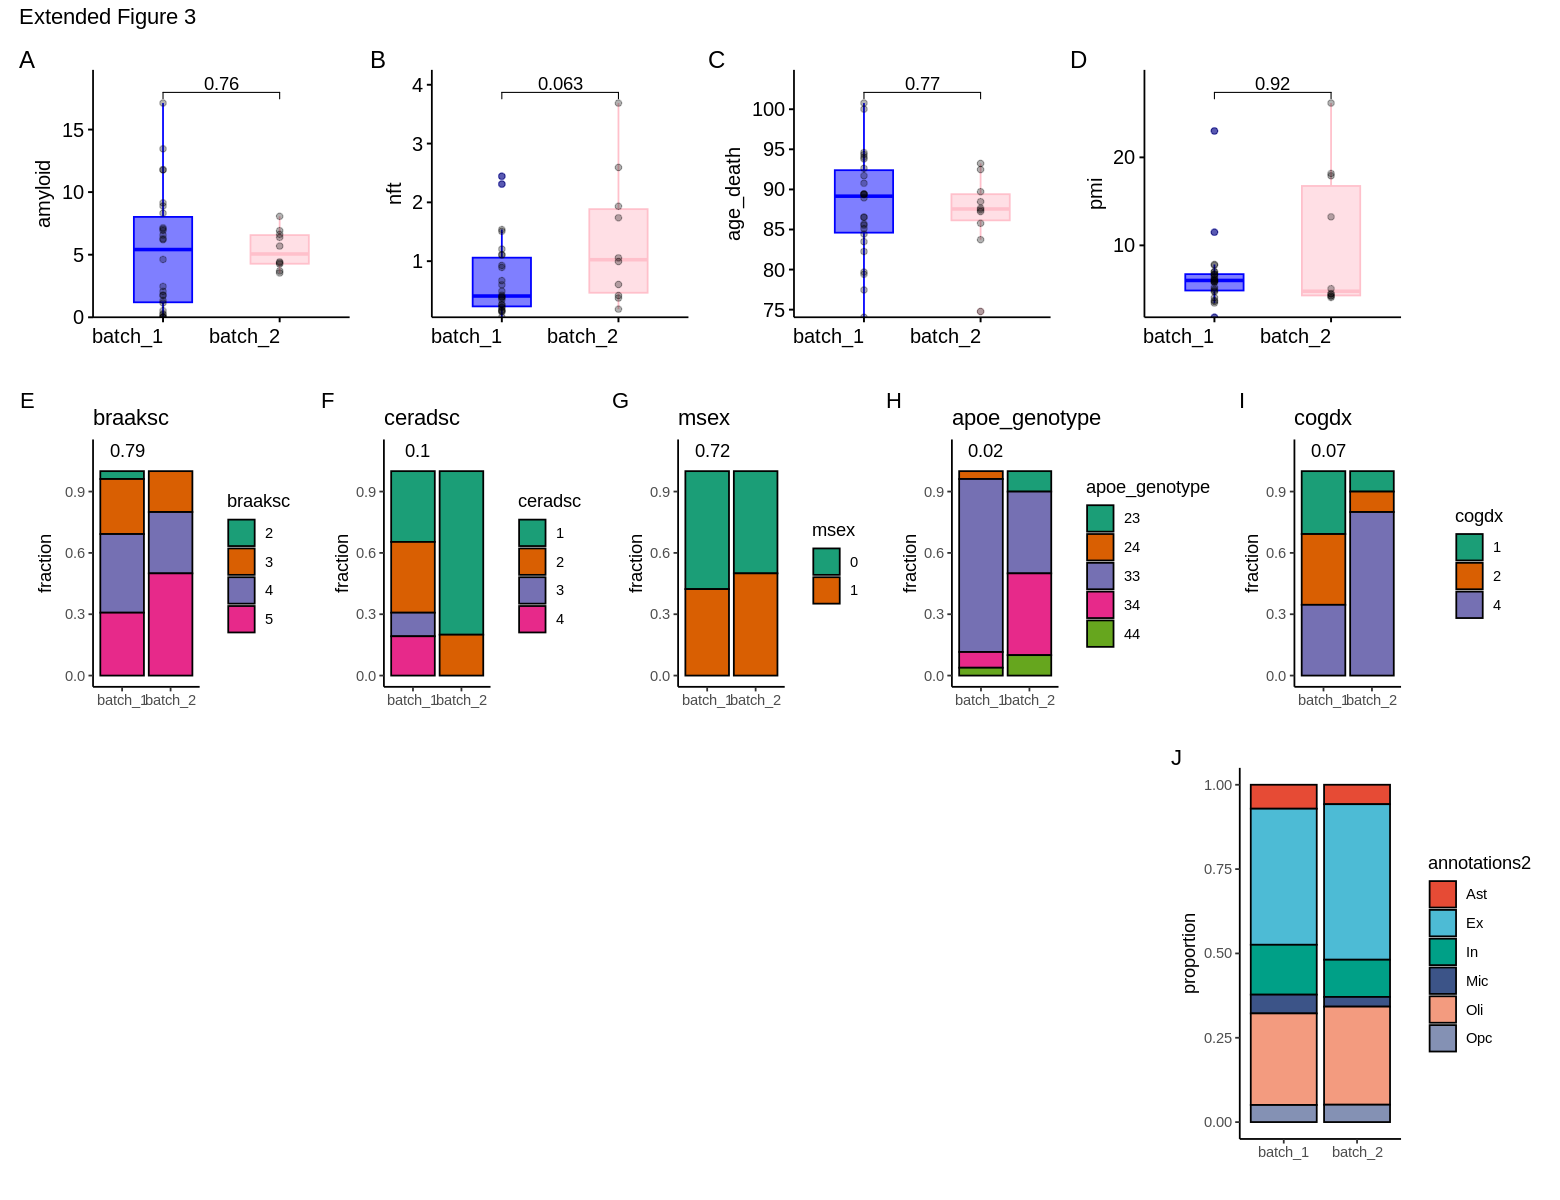

In [22]:
options(repr.plot.width=13, repr.plot.height=10)

extended2 = (cont_plots / disc_plots / (plot_spacer()|plot_spacer()| plot_spacer() |plot_spacer()| plot_spacer()|plot_spacer()  | props)) + plot_layout(heights=c(2,2,3)) + plot_annotation(tag_levels = 'A', title='Extended Figure 3')

extended2 


In [23]:
pdf('./pdf_figures/Extended_Figure_3.pdf', width=13, height=10)
extended2
dev.off()

Warning message in wilcox.test.default(c(0, 1.15125, 11.79375, 0.531, 0, 6.93833333333333, :
“cannot compute exact p-value with ties”
Warning message in wilcox.test.default(c(6, 5.25, 5.83333333333333, 7, 4.08333333333333, :
“cannot compute exact p-value with ties”


png 
  2

#### Extended Figure QC and celltype anno overview

In [56]:
library(RColorBrewer)
library(tidyHeatmap)
library(ComplexHeatmap)


plot_coords_by_grp = function (df, x_name, y_name, annotation_name, alpha_name, colors) 
{
    df = (df[, c(x_name, y_name, annotation_name, alpha_name)])
    colnames(df) = c("x_name", "y_name", "annotation_name", "alpha_name")
    plot = ggplot(df, aes(x = x_name, y = y_name, color = annotation_name, 
        alpha = alpha_name)) + geom_point(size = 0.001) + theme_void() + 
        theme(panel.background = element_rect(colour = "black", 
            size = 0), legend.position = "none") + scale_color_manual(values = (colors[as.character(unique(df$annotation_name))])) + 
        ggtitle("") + theme(text = element_text(size = (11))) + 
        theme(legend.position = "bottom") + guides(colour = guide_legend(override.aes = list(size = 5))) #+ 
        #theme(legend.title = element_blank(), legend.position = "none")
    return(plot + theme(panel.background = element_rect(fill = "transparent"), 
        plot.background = element_rect(fill = "transparent", 
            color = NA), panel.grid.major = element_blank(), 
        panel.grid.minor = element_blank(), legend.background = element_rect(fill = "transparent"), 
        legend.box.background = element_rect(fill = "transparent")))
    return(plot)
}

In [57]:
all_data = readRDS('./processed_data/single_cell//stats_input_data_0825.rds')


In [58]:
# per-cell marker expression
marker_logcounts_melted = read.csv('./processed_data/for_plotting/marker_logcounts_melted.csv')
colData = read.csv('./processed_data/single_cell/colData.csv')
# various QC/stats metrics
df = read.csv('./processed_data/for_plotting/celltype_annos_qc.csv')
data = readRDS('./processed_data/for_plotting/celltype_anno_counts.rds')

# get coords data
coords = colData[,c('x', 'y', 'ABCA7LoF', 'projid', 'leiden_clusters', 'annotations2', 'gaussian_liklihood')]
coords$ABCA7LoF = ifelse(coords$ABCA7LoF==1, 'LoF', 'Con')
coords$leiden_clusters = as.character(coords$leiden_clusters)

In [59]:
# plot marker genes
marker_genes = c('SYT1', 'NRGN', 'GAD1', 'AQP4', 'CSF1R', 'MBP', 'PLP1', 'VCAN',  'PDGFRB', 'FLT1')
marker_logcounts_melted$Var1 = factor(marker_logcounts_melted$Var1, levels = marker_genes)
plt0 = ggplot(marker_logcounts_melted, aes(x = celltype, y = value, fill = celltype)) + geom_boxplot(outlier.shape = NA)  + facet_wrap(Var1 ~ ., ncol = 5, scales = 'free')+ theme_classic() + theme( strip.background = element_blank() )  + scale_fill_manual(values = colors[marker_logcounts_melted$celltype])

# plot fractions
cells = unique(df$celltype)
df$celltype = factor(df$celltype, levels = cells[order(cells)])
colourCount = length(unique(df$projid))
getPalette = colorRampPalette(brewer.pal(9, "Set1"))

plt1 = ggplot(df) + aes(x = factor(projid), fill = factor(celltype)) + geom_bar(color = "black", position = "fill") + ggtitle('individual-level cell fractions') + xlab("LoF variants") + ylab("fraction") + theme_classic() + labs(x = "", fill = 'fraction') + scale_fill_manual(values = colors[as.character(df$celltype)]) + facet_grid(. ~ LOF, scales = "free", space = "free") + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plt2 = ggplot(df) + aes(fill = factor(projid), x = factor(celltype)) + geom_bar(color = "black", position = "fill") + ggtitle('cell-level individual fractions') + xlab("LoF variants") + ylab("fraction") + theme_classic() + labs(x = "", fill = 'fraction') + scale_fill_manual(values = getPalette(colourCount)) + theme(legend.position = "none")

# plot correlation heatmap
C = unname(colors[c('Ex', 'In', 'Ast', 'Mic', 'Oli', 'Opc')])

d = data$ind_cor%>%melt(.)%>%mutate(X=Var1)%>%mutate(Y=Var2)%>%
separate(., 'Var1', c('From_celltype', 'From_projid'), '[.]')%>%
separate(., 'Var2', c('To_celltype', 'To_projid'), '[.]')

plt3 = d%>%as_tibble(.)%>%
tidyHeatmap::heatmap(column_title='',row_title='',.row = X,.column = Y,.value = value,show_heatmap_legend =TRUE,show_column_names=F, show_row_names=F, palette_value = circlize::colorRamp2(seq(0, 1, length.out = 11), rev(RColorBrewer::brewer.pal(11, "RdBu"))), clustering_distance_rows='pearson', clustering_distance_columns='pearson')%>%
add_tile(From_celltype, palette=C, show_annotation_name=FALSE)%>%
add_tile(To_celltype, palette=C, show_annotation_name=FALSE, show_legend=FALSE)%>%wrap_heatmap()

# plot correlation as boxplot
df_subset = data$cross_cors
df_subset$celltype1 = as.character(df_subset$celltype1)
df_subset$celltype2 = as.character(df_subset$celltype2)
plt4 = ggplot(df_subset) + aes(fill = factor(celltype1), x = factor(celltype1), y = value) + geom_boxplot() + ylab("individual correlations") + theme_classic() + scale_fill_manual(values = colors[as.character(df_subset$celltype1)]) + theme(legend.position = "none")

# plot barplots
df = data$median_cells
df$celltype = as.character(df$celltype)
plt5 = ggplot(df) + aes(fill = factor(celltype), x = factor(celltype), y = median) + geom_bar(color = "black", stat="identity") + ylab("Median cells/ind.") + theme_classic() + scale_fill_manual(values = colors[as.character(df$celltype)]) + theme(legend.position = "none")
df = data$N_cells
df$celltype = as.character(df$celltype)
plt6 = ggplot(df) + aes(fill = factor(celltype), x = factor(celltype), y = N) + geom_bar(color = "black", stat="identity") + ylab("N cells/ind.") + theme_classic() + scale_fill_manual(values = colors[as.character(df$celltype)]) + theme(legend.position = "none") + 
  geom_text(label = df$N, vjust = 1.5, colour = "white")

df = data$no_cells
plt7 = ggplot(df) + aes(fill = factor(celltype), x = factor(celltype), y = N) + geom_bar(color = "black", stat="identity") + ylab("No cells/ind.") + theme_classic() + scale_fill_manual(values = colors[as.character(df$celltype)]) + theme(legend.position = "none") + 
  geom_text(label = df$N, vjust = 1.5, colour = "white")

# add some plot formatting
plt0 = plt0 + ylab('') + xlab('') +  theme(axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank())
plt1 = plt1 + ggtitle('')+  theme(axis.title.x=element_blank(),axis.text.x=element_blank(), axis.ticks.x=element_blank())
plt2 = plt2 + ggtitle('') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plt4 = plt4 + xlab('') +ggtitle('')+ theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plt5 = plt5 + xlab('') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plt6 = plt6 + xlab('') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
plt7 = plt7 + xlab('') + theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

# show additional coord info 
n <- length(unique(coords$leiden_clusters))
qual_col_pals = brewer.pal.info[brewer.pal.info$category == 'qual',]
col_vector = unlist(mapply(brewer.pal, qual_col_pals$maxcolors, rownames(qual_col_pals)))
names(col_vector) = as.character(unique(coords$leiden_clusters))
C2 = plot_coords_by_grp(coords, 'x', 'y', 'leiden_clusters', 'gaussian_liklihood', col_vector)

# also show cluster enrichments below
df = read.csv('./processed_data/single_cell/celltype_scores.csv') %>% melt(., id.vars = 'X')
colData = read.csv('./processed_data/single_cell/colData.csv')
temp = coords[!duplicated(coords$leiden_clusters),]
rownames(temp) = temp$leiden_clusters
df$anno = temp[as.character(df$X),'annotations2']

df$X = as.character(df$X)

plt8 = df%>%as_tibble(.)%>%
tidyHeatmap::heatmap(column_title='Celltype Marker',row_title='Leiden Clusters',.row = X,.column = variable,.value = value,show_heatmap_legend =TRUE,palette_value = circlize::colorRamp2(seq(-3, 3, length.out = 11), rev(RColorBrewer::brewer.pal(11, "RdBu"))), clustering_distance_rows='pearson', clustering_distance_columns='pearson', scale='row')%>%
add_tile(anno, palette=C, show_annotation_name=FALSE)%>%wrap_heatmap()

# cladogram
temp = all_data$av_logcounts_by_cluster_full_matrix
names = unlist(lapply(colnames(temp), function(x) strsplit(x, '[.]')[[1]][1]))
out = apply(temp, 1, function(x){aggregate(x, by=list(names=names), 'mean')})
                      
out = do.call('cbind', out)

N = unlist(lapply(colnames(out), function(x) endsWith(x, '.x')))
out2 = out[,N]
rownames(out2) = out$SAMD11.names
out2 = t(out2)
cor_clusters = cor(out2[rowVars(out2)>0,])

df = colData[!duplicated(colData$leiden_clusters),c('leiden_clusters', 'annotations2')]
rownames(df) = as.character(df$leiden_clusters)
cellnames = df[colnames(cor_clusters),'annotations2']
Col = colors[cellnames]
rownames(cor_clusters) = unlist(lapply(1:length(colnames(cor_clusters)), function(x) paste0(cellnames[x], '.C', colnames(cor_clusters)[x])))
                  
options(repr.plot.width=5, repr.plot.height=8)

D <- dist(cor_clusters)
HC <- hclust(D)
pdf('./pdf_figures/Extended_Figure_4clado.pdf', width = 5, height=8)
P = plot(ape::as.phylo(HC), type="cladogram", tip.color=Col)
dev.off()

png 
  2

In [35]:
# get correlation means
temp = d[d$From_celltype==d$To_celltype,]
mean(aggregate(temp$value, list(temp$From_celltype), 'mean')$x)

[1] 0.9477321

In [36]:
data$median_cells

,median,celltype
,<dbl>,<fct>
Ast,170.0,Ast
Ex,928.0,Ex
In,365.0,In
Mic,150.5,Mic
Oli,620.0,Oli
Opc,155.0,Opc


In [63]:
df = readRDS('./raw_data/genesets/RefCellTypeMarkers.adultBrain.rds')
df = lapply(df, function(x) x[x%in%rownames(out2)])
            
out2 = all_data$av_logcounts_by_celltype
o = lapply(names(df), function(x) colMeans((out2[df[[x]],])))
           
temp = as.data.frame(do.call('rbind', o))
rownames(temp) = names(df)
temp = temp[!rownames(temp)%in%c('Per', 'Endo'),]           
temp = temp[c('Ex', 'In', 'Ast', 'Mic', 'Oli', 'Opc'),c('Ex', 'In', 'Ast', 'Mic', 'Oli', 'Opc')]
h1 = Heatmap((scale(t(temp))), name='z-score', cluster_columns = F,clustering_distance_columns='pearson', cluster_rows=F,column_title = 'reference 1\n(PsychEncode)',, rect_gp = gpar(col = "black", lwd = 1))
           
df = readRDS('./raw_data/genesets/PanglaoDB.by.organ.by.celltype.rds')
df = df$Brain
df = lapply(df, function(x) x[x%in%rownames(out2)])
            
out2 = all_data$av_logcounts_by_celltype
o = lapply(names(df), function(x) colMeans((out2[df[[x]],])))
           
temp2 = as.data.frame(do.call('rbind', o))
rownames(temp2) = names(df)
temp2 = temp2[rownames(temp2)%in%c('Pyramidal cells', 'Neurons','Glutaminergic neurons', 'GABAergic neurons', 'Astrocytes', 'Oligodendrocytes', 'Microglia',  'Oligodendrocyte progenitor cells'),]
N = c('Neurons', 'Pyramidal cells', 'Glutaminergic neurons','GABAergic neurons', 'Astrocytes', 'Microglia', 'Oligodendrocytes', 'Oligodendrocyte progenitor cells')
temp2 = temp2[(N),c('Ex', 'In', 'Ast', 'Mic', 'Oli', 'Opc')]
h2 = Heatmap((scale(t(temp2))), clustering_distance_columns='pearson', cluster_columns = F,cluster_rows=F, column_title = 'reference 2\n(PanglaoDB)', show_heatmap_legend = F, rect_gp = gpar(col = "black", lwd = 1))

pdf('./pdf_figures/Extended_Figure_4_marker_hmap.pdf', width = 4.5, height=4.5)
h1+h2
dev.off()

png 
  2

In [41]:
png('./pdf_figures/Extended_Figure_4_cells1.png', res=300, width=5000, height=5500)
C2
dev.off()

png 
  2

In [67]:
options(repr.plot.width=6, repr.plot.height=5)

pdf('./pdf_figures/Extended_Figure_4_hmap.pdf', width=6, height=5)
plt3
dev.off()

png 
  2

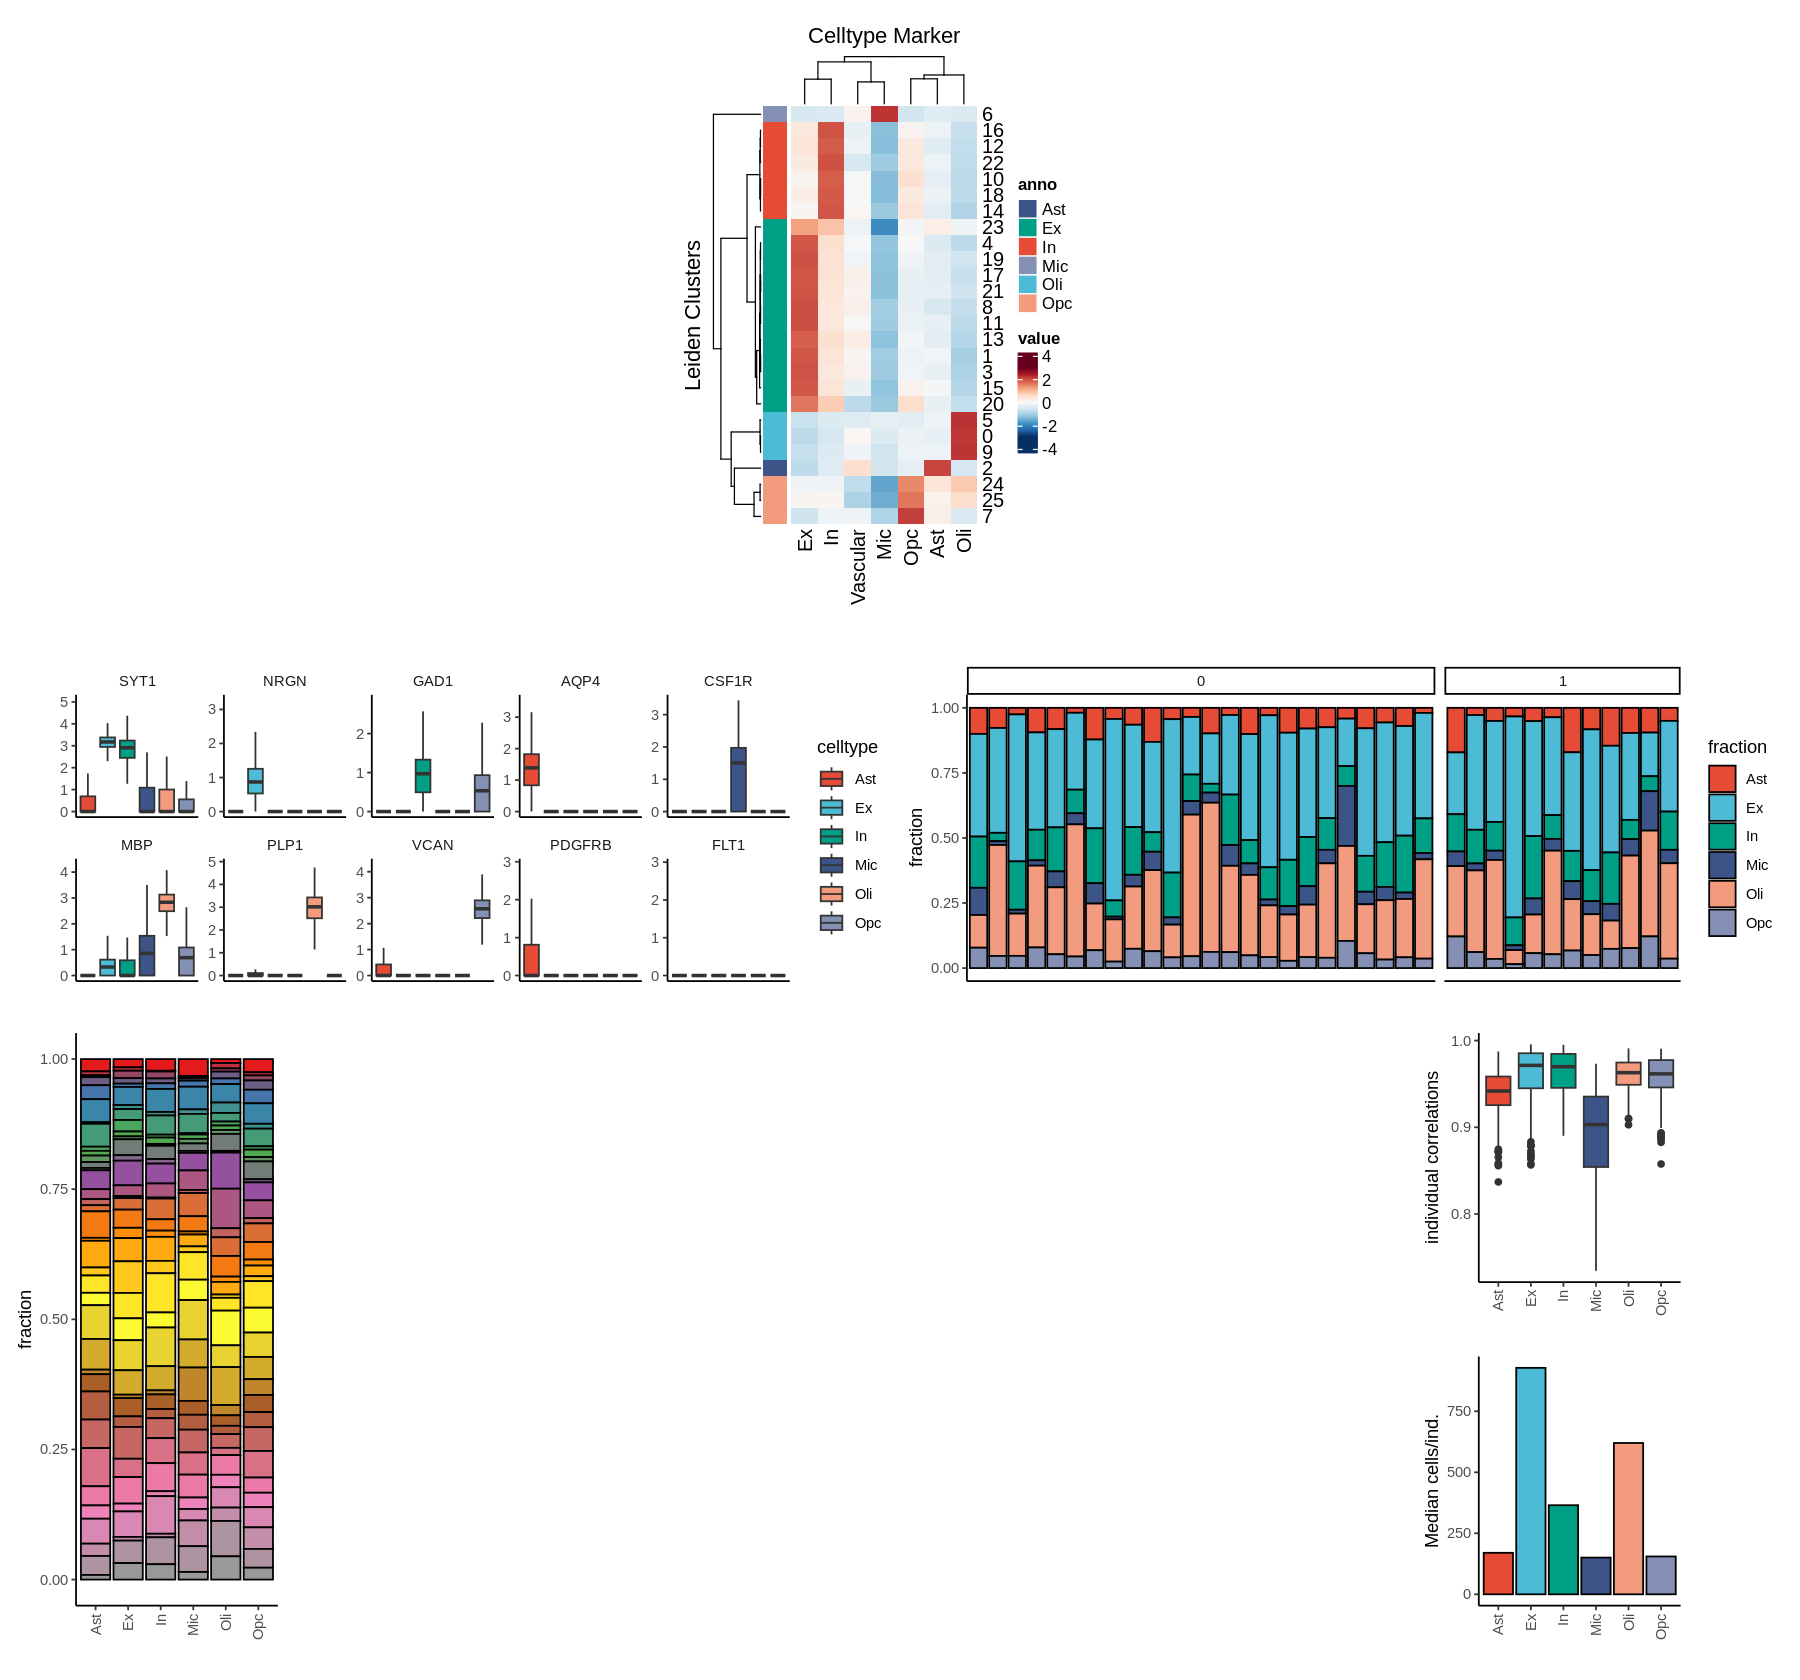

In [52]:
options(repr.plot.width=15, repr.plot.height=14)

extended4 = (((((plot_spacer()))|plt8|plot_spacer())+plot_layout(widths=c(1,.7,1)))/(plt0|plt1)/((plt2|plot_spacer()|(plt4/plt5))+plot_layout(widths=c(.4,2.2,.4)))) + plot_layout(heights=c(4.2,2,4))
extended4

In [53]:
pdf('./pdf_figures/Extended_Figure_4.pdf', width=15, height=14)
extended4
dev.off()

png 
  2

#### Extended Figure gene score correlations

In [58]:
# plot deg correlations
degs = readRDS('./processed_data/single_cell/pseudobulk_degs_0825.rds')

out = lapply(names(degs$degs_all), function(x) merge(degs$degs_all[[x]]$res, degs$degs_exclude_both[[x]]$res, by = 0))
names(out) = names(degs$degs_all)        

plt1a = plot_degs(out$Ex, out$Ex[order(out$Ex$P.Value.x, decreasing=F),'Row.names'][1:5], 'Excitatory neurons') # choose specific genes of interest to show
plt2a = plot_degs(out$In,  out$In[order(out$In$P.Value.x, decreasing=F),'Row.names'][1:5], 'Inhibitory neurons')
plt3a = plot_degs(out$Ast,  out$Ast[order(out$Ast$P.Value.x, decreasing=F),'Row.names'][1:5], 'Astrocytes')
plt4a = plot_degs(out$Mic,  out$Mic[order(out$Mic$P.Value.x, decreasing=F),'Row.names'][1:5], 'Microglia')
plt5a = plot_degs(out$Oli,  out$Oli[order(out$Oli$P.Value.x, decreasing=F),'Row.names'][1:5], 'Oligodendrocytes')
plt6a = plot_degs(out$Opc,  out$Opc[order(out$Opc$P.Value.x, decreasing=F),'Row.names'][1:5], 'OPCs')


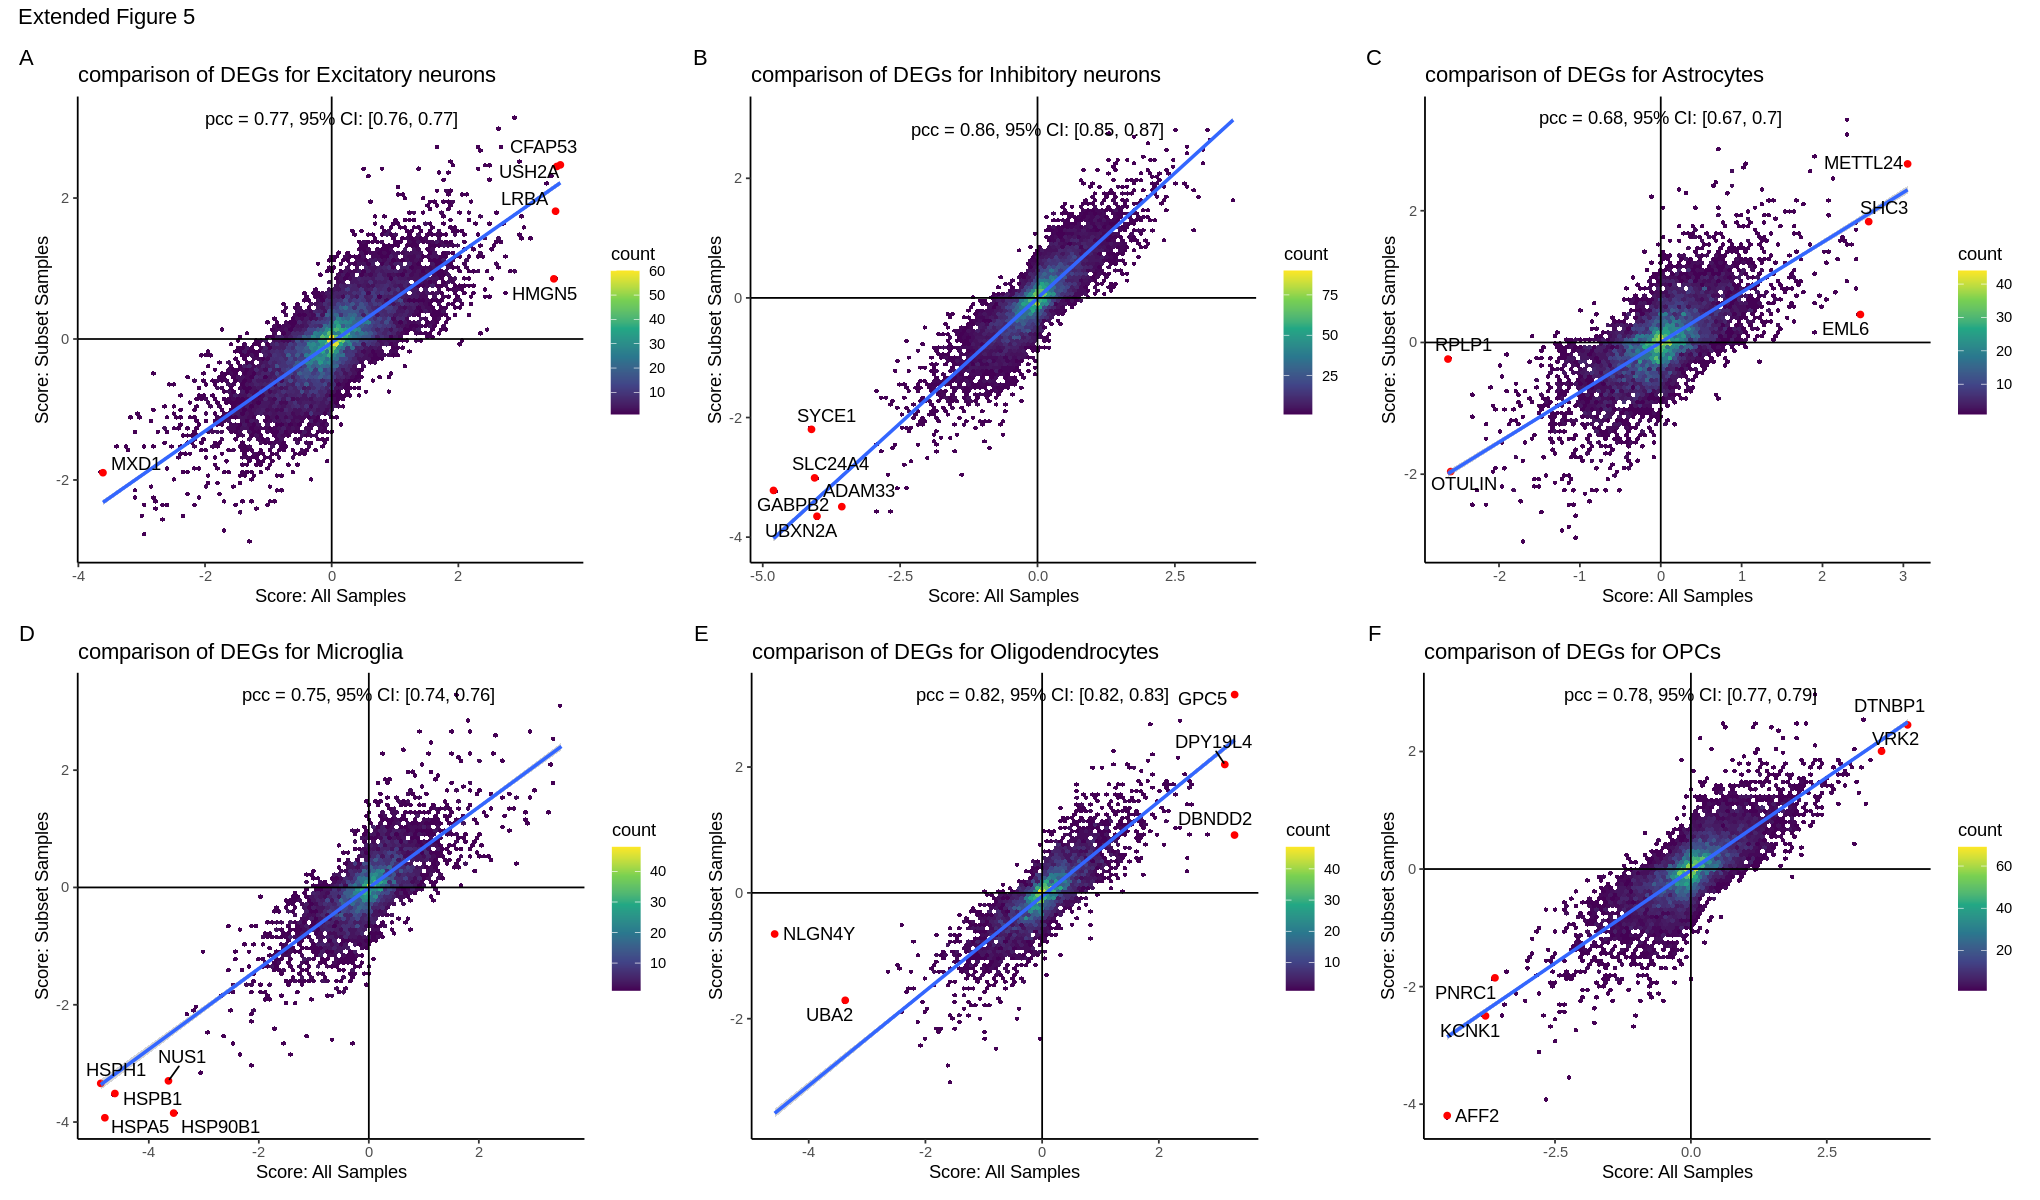

In [59]:
options(repr.plot.width=17, repr.plot.height=10)

#extended5 = ((p|plot_spacer()|plot_spacer()) / ((plt1a | plt2a|plt3a)/(plt4a|plt5a|plt6a))) + plot_layout(heights=c(1,3))+ plot_annotation(tag_levels = 'A', title='Extended Figure 5')
extended5 = (((plt1a | plt2a|plt3a)/(plt4a|plt5a|plt6a)))+ plot_annotation(tag_levels = 'A', title='Extended Figure 5')
extended5

In [124]:
pdf('./pdf_figures/Extended_Figure_5.pdf', width=15, height=10)
extended5
dev.off()

png 
  2

#### Extended Figure umap cluster distributions

In [3]:
#overview = image_ggplot(image_read('./pdf_figures/umap_exp_overview.pdf'))#, native = TRUE)

ex_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Exumap_colored_up.pdf'))#, native = TRUE)
in_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Inumap_colored_up.pdf'))#, native = TRUE)
ast_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Astumap_colored_up.pdf'))#, native = TRUE)
mic_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Micumap_colored_up.pdf'))#, native = TRUE)
oli_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Oliumap_colored_up.pdf'))#, native = TRUE)
opc_up = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Opcumap_colored_up.pdf'))#, native = TRUE)

ex_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Exumap_colored_down.pdf'))#, native = TRUE)
in_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Inumap_colored_down.pdf'))#, native = TRUE)
ast_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Astumap_colored_down.pdf'))#, native = TRUE)
mic_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Micumap_colored_down.pdf'))#, native = TRUE)
oli_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Oliumap_colored_down.pdf'))#, native = TRUE)
opc_down = image_ggplot(image_read_pdf('./pdf_figures/Extended_Figure_6_Opcumap_colored_down.pdf'))#, native = TRUE)

hist = image_ggplot(image_trim(image_read_pdf('./pdf_figures/Extended_Figure_6_cluster_hist.pdf')))

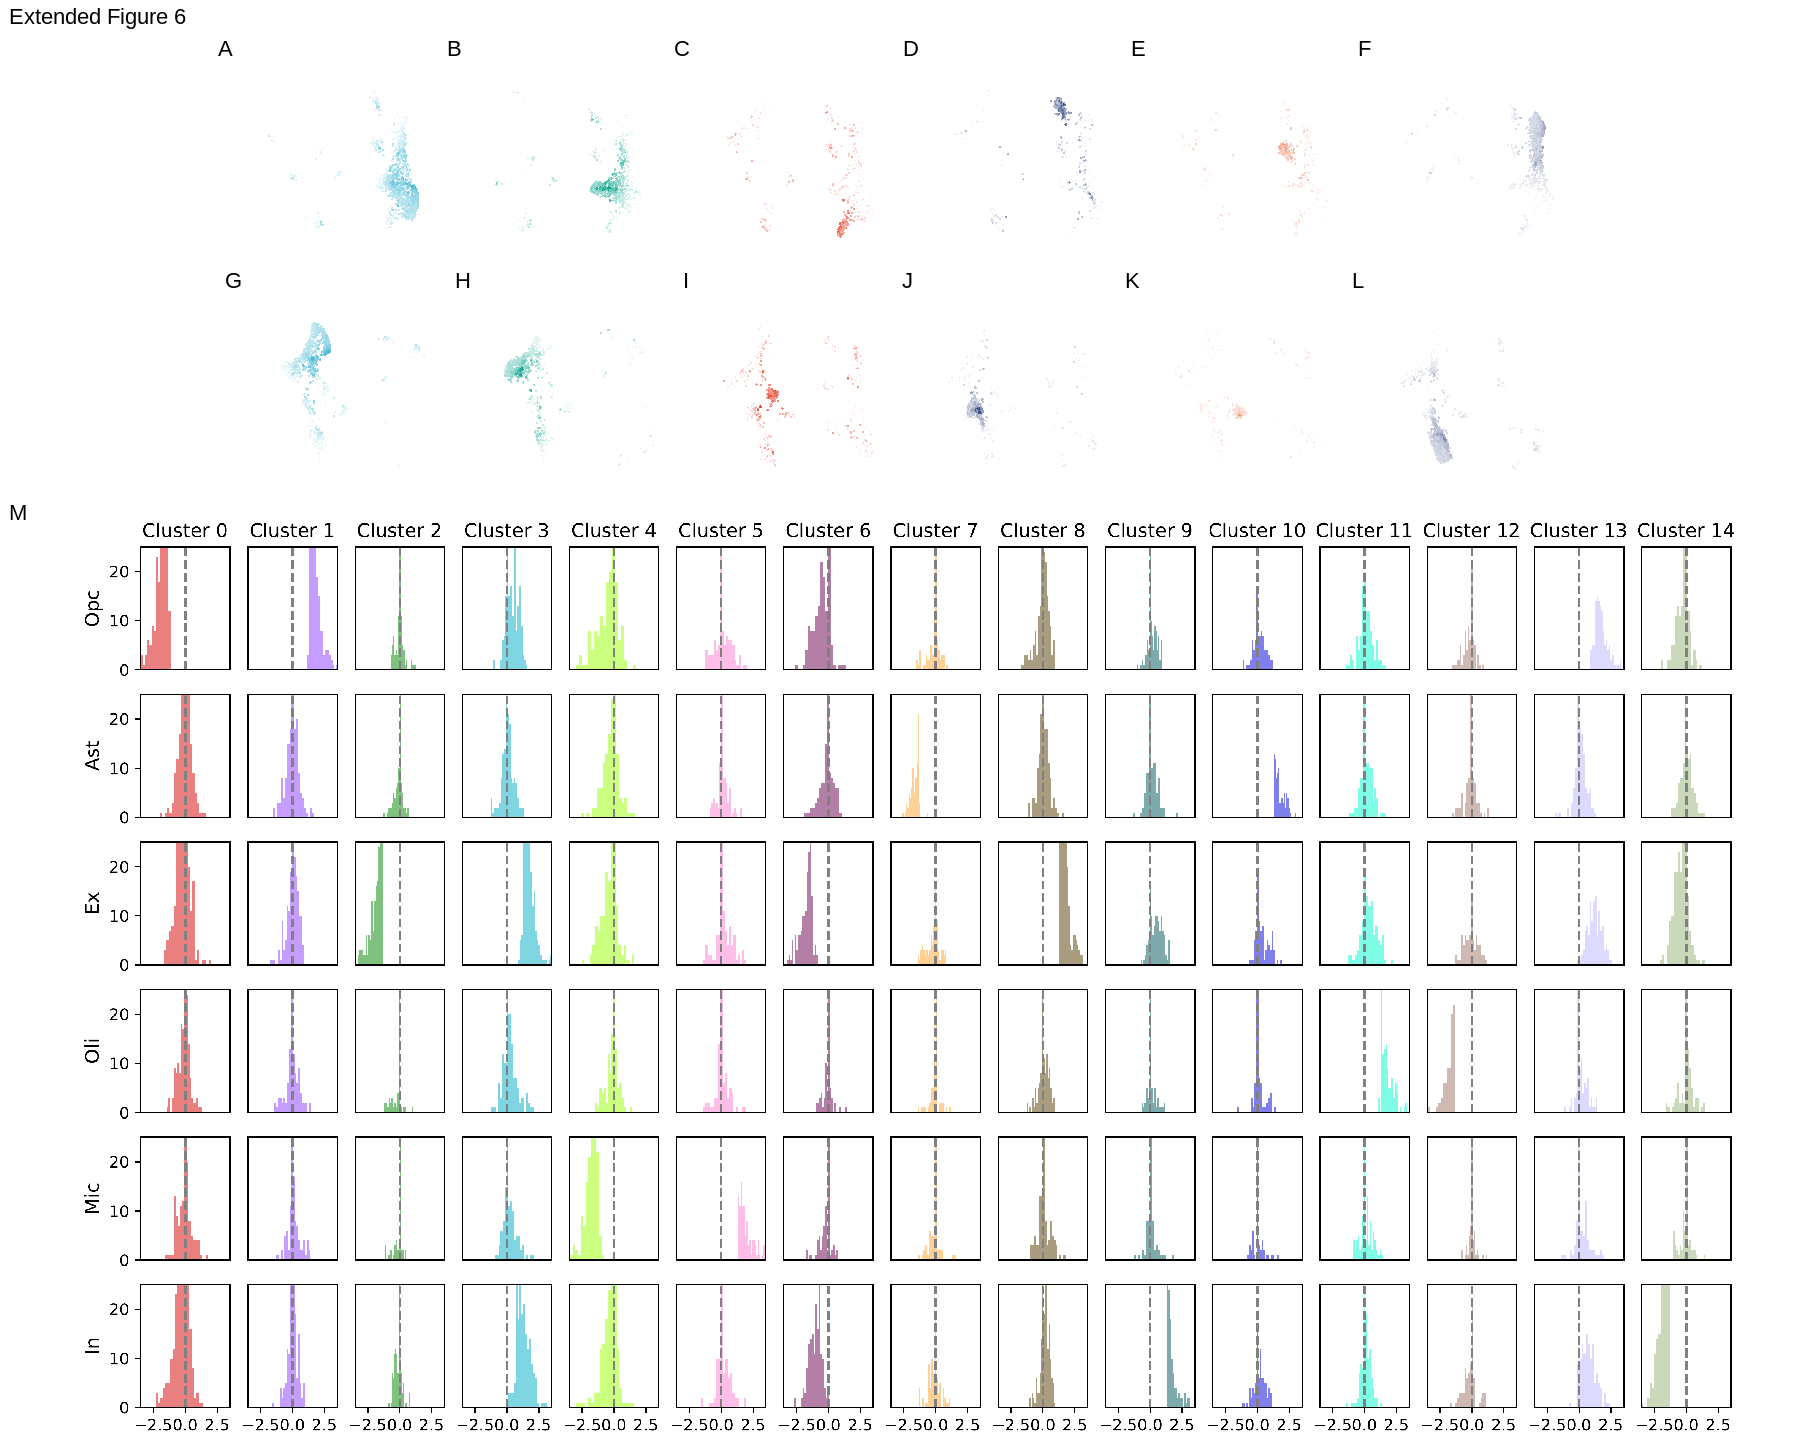

In [4]:
options(repr.plot.width=15, repr.plot.height=12)

col1 = ex_up | in_up | ast_up | mic_up | oli_up | opc_up
col2 = ex_down | in_down | ast_down | mic_down | oli_down | opc_down
ex6 = (col1/col2/hist) + plot_layout(heights=c(7,7,30))+ plot_annotation(tag_levels = 'A', title='Extended Figure 6')
ex6

In [5]:
pdf('./pdf_figures/Extended_Figure_6.pdf', width=15, height=12)
ex6
dev.off()

png 
  2

#### Extended Figure ABCA7 expression

In [62]:
library(ggpubr)
library(cowplot)


Attaching package: ‘cowplot’


The following object is masked from ‘package:ggpubr’:

    get_legend


The following object is masked from ‘package:patchwork’:

    align_plots




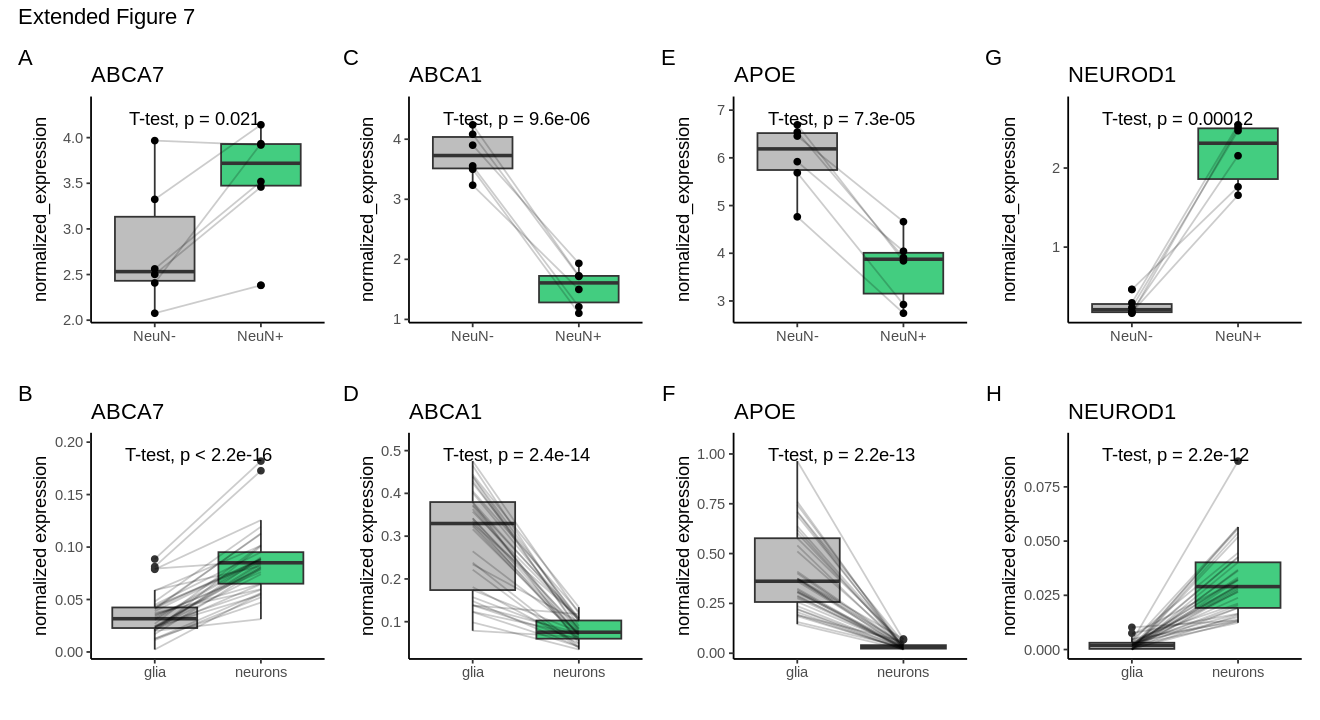

In [64]:
options(repr.plot.width=11, repr.plot.height=6)

ex7 = (plots1) + plot_annotation(tag_levels = 'A', title='Extended Figure 7') 
ex7

png 
  2

#### Extended Figure Lipidomics

In [3]:
# lipidomics data
data = readRDS('../ABCA7lof//processed_data/for_plotting/lipidomics.rds')
key = read.csv('../ABCA7lof/raw_data/ngn2_data/lipidkey.csv', sep = '\t')
key = key[!duplicated(key$Key),]
rownames(key) = key$Key

In [8]:
sce = data$ngn2_all
sce = sce[,sce$treatment!='Choline']

# plot correlations
d = cor(counts(sce)) %>% melt(.)
d$LoF = ifelse(colData(sce)[d$Var1,'Genotype']=='Control', 'WT', 'KO#1')
d$LoF2 = ifelse(colData(sce)[d$Var2,'Genotype']=='Control', 'WT', 'KO#1')
d$b = colData(sce)[d$Var1,'treatment']
d$b2 = colData(sce)[d$Var2,'treatment']
d$b = ifelse(d$b=='H2O', 'batch_1', 'batch_2')
d$b2 = ifelse(d$b2=='H2O', 'batch_1', 'batch_2')

p2 = d %>% as_tibble(.) %>%
tidyHeatmap::heatmap(column_title='',row_title='',.row = Var1,.column = Var2,.value = value,show_heatmap_legend =TRUE, show_row_names=F, show_column_names=F, palette_value = circlize::colorRamp2(seq(0, 1, length.out = 11), rev(RColorBrewer::brewer.pal(11, "RdBu"))), clustering_distance_columns='pearson', clustering_distance_rows='pearson')%>%
add_tile(LoF, palette=c('grey', 'blue'), show_annotation_name=FALSE, show_legend=TRUE)%>%
add_tile(LoF2, palette=c('grey', 'blue'), show_annotation_name=FALSE, show_legend=FALSE)%>%
add_tile(b, palette=c('purple', 'orange'), show_annotation_name=FALSE, show_legend=TRUE)%>%
add_tile(b2, palette=c('purple', 'orange'), show_annotation_name=FALSE, show_legend=FALSE)%>%wrap_heatmap()

# plot scatterplot between batches
sample1 = sign(rowData(sce)$stats.log_ratio.s2.over.s1.)*rowData(sce)$stats.log_p_value.s2.over.s1.
sample2 = sign(rowData(sce)$stats.log_ratio.s4.over.s3.)*rowData(sce)$stats.log_p_value.s4.over.s3.
df = as.data.frame(cbind(sample1, sample2))
df$Row.names = rowData(sce)$lipid.class
df$Row.names = ifelse(abs(df$sample1)>1.3 & abs(df$sample2)>1.3, df$Row.names, '')
gene = c('Cer','PC','TG')
p3 = plot_lipid_diff(df, gene, 'WT vs KO#1 lipid changes by batch', 'WT vs KO#1 batch 2', 'WT vs KO#1 batch 1') #+ xlim(-2.5,5) + ylim(-2.5,5)


In [17]:
# plot pm table
d = rowData(data$pm_all)
d$change = ifelse(d$stats.pvalue<0.05 & d$stats.log2>0,'up', ifelse(d$stats.pvalue<0.05 & d$stats.log2< 0,'down', 'unchanged'))
# plot table
tbl = as.data.frame(table(d$lipid.key, d$change))
tbl = as.data.frame(tbl%>%pivot_wider(values_from=Freq, names_from=Var2))
tbl$total = rowSums(cbind(tbl$up, tbl$down))
tbl$total = rowSums(cbind(tbl$up, tbl$down))
tbl = tbl[order(tbl$total, decreasing=TRUE),]

tbl$percentage = round(tbl$total/(tbl$total+tbl$unchanged), 2)*100
tbl = as.data.frame(tbl)
rownames(tbl) = tbl$Var1
tbl$Var1 = NULL
tbl = tbl[, c('up', 'down', 'total', 'percentage')]
colnames(tbl) = c('U', 'D', 'T', '%')
tbl$Name = key[rownames(tbl),c('subclass')]
tbl = tbl[tbl$T!=0,]
p7 = gridExtra::tableGrob(tbl)


In [ ]:
options(repr.plot.width=10, repr.plot.height=9)

extended11 = (p2 | p3) / p7
extended11

In [ ]:
# save the PM supp table
meta = rowData(data$pm_all)
T = meta[, !colnames(meta)%in%c('names')]
write.csv(T, './supplementary_tables/pm_lipidomic.csv')

In [105]:
pdf('./pdf_figures/Extended_Figure_11.pdf', width=10, height=9)
extended11
dev.off()

png 
  2